In [1]:
import sys
import json
import shutil
from pathlib import Path
import numpy as np
import torch
import cv2
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from PIL import Image

from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, precision_recall_curve
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

In [2]:
# Auto-detect project root
ROOT = Path.cwd().parent
# while not ((ROOT / "src").exists() and (ROOT / "data").exists()):
#     ROOT = ROOT.parent

print("Project root:", ROOT)

# Add ground_truth to path
sys.path.append(str(ROOT / "src" / "ground_truth"))

from models import SpatialModel
import build_features

Project root: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# CelebDF paths (external dataset)
CELEB_REAL_DIR = ROOT / "Dataset" / "Celeb_real_face_only"
CELEB_FAKE_DIR = ROOT / "Dataset" / "Celeb_fake_face_only"

DATA_DIR = ROOT / "data"
LABELS_PATH = DATA_DIR / "labels.json"

FRAMES_OUT = ROOT / "preprocessed" / "frames" / "test_celebdf"
EMB_OUT = ROOT / "embeddings" / "test_celebdf"

OUT_EVAL = ROOT / "checkpoints" / "eval_celebdf"
OUT_EVAL.mkdir(parents=True, exist_ok=True)

SPATIAL_CKPT = ROOT / "checkpoints" / "spatial" / "spatial_best_valAUC.pth"
ENSEMBLE_ARTIFACT = ROOT / "checkpoints" / "ensemble_final" / "ensemble_artifacts.joblib"

FRAMES_PER_VIDEO = 8

Device: cuda


In [4]:
real_videos = sorted(CELEB_REAL_DIR.glob("*.mp4"))
fake_videos = sorted(CELEB_FAKE_DIR.glob("*.mp4"))
all_videos = real_videos + fake_videos

print(f"Found {len(real_videos)} real + {len(fake_videos)} fake videos")

with open(LABELS_PATH) as f:
    labels_map = json.load(f)

added = 0
for v in all_videos:
    if v.stem not in labels_map:
        labels_map[v.stem] = 1 if "fake" in v.parent.name.lower() else 0
        added += 1

if added > 0:
    shutil.copy2(LABELS_PATH, LABELS_PATH.with_suffix(".bak"))
    with open(LABELS_PATH, "w") as f:
        json.dump(labels_map, f, indent=2)
    print(f"Added {added} new labels (backup created)")
else:
    print("All CelebDF labels already present")

Found 588 real + 580 fake videos
All CelebDF labels already present


In [5]:
FRAMES_OUT.mkdir(parents=True, exist_ok=True)

def extract_frames(video_paths):
    for v in tqdm(video_paths, desc="Extracting frames"):
        out_dir = FRAMES_OUT / v.stem
        if (out_dir / "frame_00.jpg").exists():
            continue

        out_dir.mkdir(parents=True, exist_ok=True)
        cap = cv2.VideoCapture(str(v))
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total <= 0:
            cap.release()
            continue

        idxs = np.linspace(0, total - 1, FRAMES_PER_VIDEO, dtype=int)
        for i, idx in enumerate(idxs):
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                cv2.imwrite(str(out_dir / f"frame_{i:02d}.jpg"), frame)
        cap.release()

extract_frames(all_videos)

Extracting frames:   0%|          | 0/1168 [00:00<?, ?it/s]

In [6]:
EMB_OUT.mkdir(parents=True, exist_ok=True)

spatial = SpatialModel(backbone_name="efficientnet_b3", pretrained=False).to(DEVICE)
ck = torch.load(SPATIAL_CKPT, map_location="cpu")
state = {k.replace("module.", ""): v for k, v in ck.get("model_state", ck).items()}
spatial.load_state_dict(state, strict=False)
spatial.eval()

import torchvision.transforms as T
tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

for vid_dir in tqdm(sorted(FRAMES_OUT.iterdir()), desc="Embedding"):
    out = EMB_OUT / f"{vid_dir.name}.npy"
    if out.exists():
        continue

    imgs = []
    for p in sorted(vid_dir.glob("*.jpg")):
        try:
            imgs.append(tfms(Image.open(p).convert("RGB")))
        except:
            pass

    if not imgs:
        continue

    batch = torch.stack(imgs).to(DEVICE)
    with torch.no_grad():
        feats = spatial.backbone(batch)
    np.save(out, feats.cpu().numpy())

Embedding:   0%|          | 0/1168 [00:00<?, ?it/s]

In [7]:
build_features.ROOT = ROOT  # force correct project root

build_features.EMB_DIR = ROOT / "embeddings"
build_features.OUT_DIR = ROOT / "ensemble_features_final"

build_features.SPATIAL_CKPT = ROOT / "checkpoints" / "spatial" / "spatial_best_valAUC.pth"
build_features.TEMPORAL_CKPT = ROOT / "checkpoints" / "temporal" / "temporal_best_valAUC.pth"

print("build_features ROOT:", build_features.ROOT)
print("Spatial CKPT:", build_features.SPATIAL_CKPT)
print("Temporal CKPT:", build_features.TEMPORAL_CKPT)

build_features ROOT: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC
Spatial CKPT: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\checkpoints\spatial\spatial_best_valAUC.pth
Temporal CKPT: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\checkpoints\temporal\temporal_best_valAUC.pth


In [8]:
spatial_head, temporal_model = build_features.load_models()
build_features.process_split("test_celebdf", spatial_head, temporal_model, labels_map)

Loading models on cuda...
Feature dimension detected from data: 1536
Loading Spatial Checkpoint: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\checkpoints\spatial\spatial_best_valAUC.pth
Loading Temporal Checkpoint: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\checkpoints\temporal\temporal_best_valAUC.pth
Processing split: test_celebdf...


100%|██████████| 1168/1168 [00:02<00:00, 409.45it/s]


✅ Saved test_celebdf: 1168 samples (Skipped: 0) -> c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\ensemble_features_final\test_celebdf.npz


In [9]:
data = np.load(ROOT / "ensemble_features_final" / "test_celebdf.npz")
X_test, y_test = data["X"], data["y"]

artifacts = joblib.load(ENSEMBLE_ARTIFACT)
base = artifacts["base_full"]
meta = artifacts["meta"]
cal = artifacts["calibrator"]

base_probs = base.predict_proba(X_test)[:, 1].reshape(-1, 1)
final_probs = cal.predict_proba(base_probs)[:, 1] if cal else meta.predict_proba(base_probs)[:, 1]

y_pred = (final_probs >= 0.5).astype(int)

In [10]:
print("AUC:", roc_auc_score(y_test, final_probs))
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

AUC: 0.639388341543514
              precision    recall  f1-score   support

        Real       0.56      0.93      0.70       588
        Fake       0.78      0.24      0.37       580

    accuracy                           0.59      1168
   macro avg       0.67      0.59      0.53      1168
weighted avg       0.67      0.59      0.53      1168



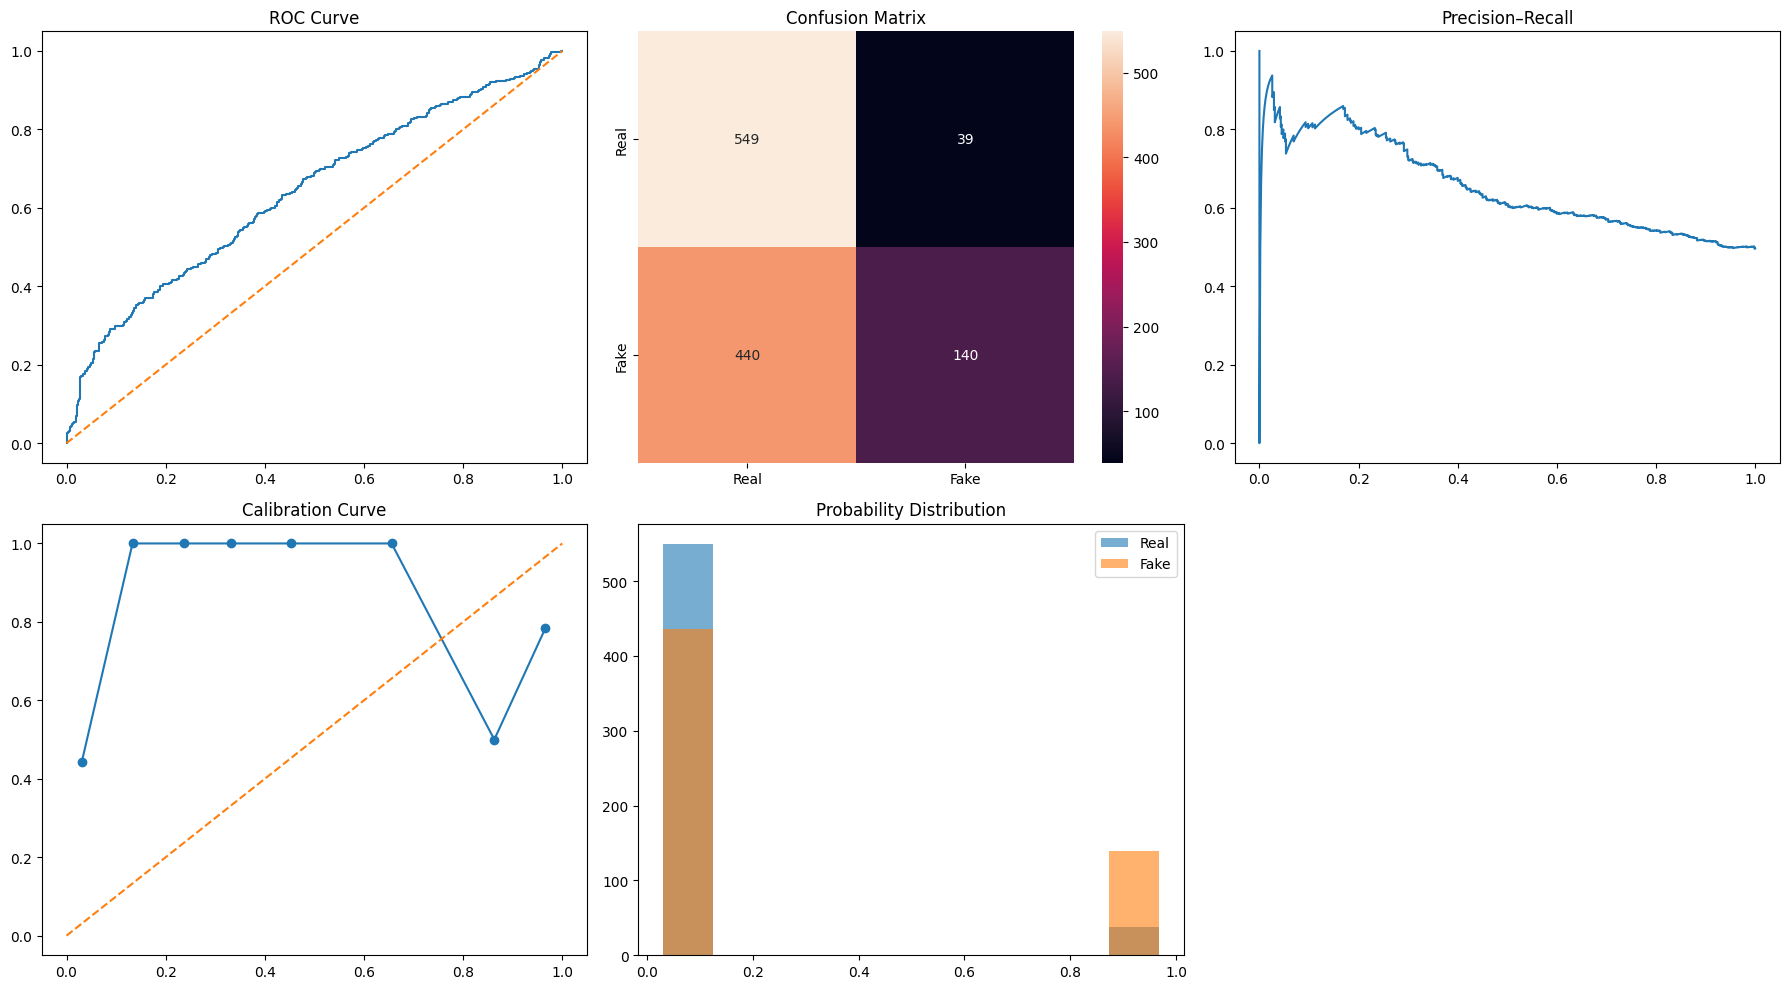

In [11]:
plt.figure(figsize=(18,10))

# ROC
fpr, tpr, _ = roc_curve(y_test, final_probs)
plt.subplot(2,3,1)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")

# Confusion
plt.subplot(2,3,2)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d",
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.title("Confusion Matrix")

# PR
prec, rec, _ = precision_recall_curve(y_test, final_probs)
plt.subplot(2,3,3)
plt.plot(rec, prec)
plt.title("Precision–Recall")

# Calibration
pt, pp = calibration_curve(y_test, final_probs, n_bins=10)
plt.subplot(2,3,4)
plt.plot(pp, pt, marker="o")
plt.plot([0,1],[0,1],'--')
plt.title("Calibration Curve")

# Histogram
plt.subplot(2,3,5)
plt.hist(final_probs[y_test==0], alpha=0.6, label="Real")
plt.hist(final_probs[y_test==1], alpha=0.6, label="Fake")
plt.legend()
plt.title("Probability Distribution")

plt.tight_layout()
plt.show()